In [2]:
from pixell import enmap, enplot, utils, curvedsky
from cosmikyu import maps, config
from cosmikyu import utils as cutils
from soapack import interfaces as soint
import healpy as hp
import numpy as np
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
output_dir = config.default_data_dir
def output_path(x):
    return os.path.join(output_dir, x)

In [7]:
sehgal_sim_path = soint.dconfig['actsims']['sehgal09_path']
SH = maps.SehgalSky2010(sehgal_sim_path, data_type='alm')

freq_idxes = ['148']
#freq_idxes = ['030', '090', '148', '219', '277', '350']
fg_loaders = {
    'ir_pts': SH.get_cib,
    'ksz': SH.get_ksz,
    'rad_pts': SH.get_radio,
    'tsz': SH.get_tsz   
}

npix = 150
res = 2 *utils.arcmin
fshape, fwcs = enmap.fullsky_geometry(res)
template = maps.get_template(fshape, fwcs)
rot_angs = [0, 20, 40, 60, 80, 100, 120, 140, 160]

for freq_idx in freq_idxes:
    for fg_idx in fg_loaders.keys():
        target_file = output_path('{}/{}_meta.txt'.format(fg_idx, freq_idx))
        if os.path.exists(target_file):
            print("skipping {} {}".format(freq_idx, fg_idx))
        else:
            print("processing {} {}".format(freq_idx, fg_idx))
            os.makedirs(output_path(fg_idx), exist_ok=True)
            
            alm = fg_loaders[fg_idx](freq_idx)
            fgmap = curvedsky.alm2map(alm, template.copy())
            meta = np.array([np.mean(fgmap), np.std(fgmap), np.max(fgmap), np.min(fgmap)])
            np.savetxt(target_file, meta, header="mean,std,max,min",
                       comments="#[{} F{} 0.5 arcmin res]   ".format(fg_idx.upper(), freq_idx))
            
            del alm, fgmap
            
#sign = np.sign(fgmap)
#fgmap = np.log(np.abs(fgmap))*sign
            
def load_meta(fg_idxes, freq_idxes):
    ret = cutils.create_dict(fg_idxes, freq_idxes)
    for freq_idx in freq_idxes:
        for fg_idx in fg_loaders.keys():
            target_file = output_path('{}/{}_meta.txt'.format(fg_idx, freq_idx)) 
            mmean, mstd, mmax, mmin = np.loadtxt(target_file)
            ret[fg_idx][freq_idx] = {'mean': mmean, 'std': mstd, 'max': mmax , 'min': mmin}
    return ret
    
metas = load_meta(list(fg_loaders.keys()), freq_idxes)
for fg_idx in fg_loaders.keys():
    for freq_idx in metas[fg_idx].keys():
        print(fg_idx, freq_idx, metas[fg_idx][freq_idx])
    


skipping 148 ir_pts
skipping 148 ksz
skipping 148 rad_pts
skipping 148 tsz
ir_pts 148 {'mean': 6723.7384318853765, 'std': 5802.902664354928, 'max': 348620.8448433348, 'min': -47906.45000015797}
ksz 148 {'mean': -0.2839407102839773, 'std': 893.8565217776382, 'max': 18863.342432725047, 'min': -15073.646521702824}
rad_pts 148 {'mean': 177.6705493477032, 'std': 10578.649128212071, 'max': 11685274.795759674, 'min': -1566864.7261491728}
tsz 148 {'mean': -1405.6462121849615, 'std': 1359.9198426649257, 'max': 2426.0212292473425, 'min': -155316.23504401118}


In [8]:
#stamp_width = stamp_height = 256*0.5*utils.arcmin
stamp_width = stamp_height = npix*res
shape, wcs, _ = maps.rand_geometry(stamp_width, stamp_height, res=res)
print(shape, wcs)

for freq_idx in freq_idxes:
    for fg_idx in fg_loaders.keys():
        for i, rot_ang in enumerate(rot_angs):
            alm = fg_loaders[fg_idx](freq_idx, euler=(0, rot_ang, 0))
            fgmap = curvedsky.alm2map(alm, template.copy()); del alm
        
            for sim_idx in np.arange(400*i, 400*(i+1)):
                target_file = output_path('stamp_{}arcmin_{}x{}/{}_{}_{}_{}arcmin_{}x{}.fits'.format(
                    '2.0', npix, npix, freq_idx, fg_idx,'%06d'%sim_idx, '2.0', npix, npix))

                if os.path.exists(target_file):
                    continue
                else:
                    if sim_idx %100 == 0:
                        print("generating {}".format(target_file))

                    _, _, pos = maps.rand_geometry(stamp_width, stamp_height, shape=shape, seed=sim_idx)
                    stamp = enmap.submap(fgmap, pos)
                    if shape != stamp.shape: 
                        assert(False)
                    enmap.write_fits(target_file, stamp); del stamp

                    #print(pos, enmap.submap(template, pos).shape)
                    #temp = enmap.extract(fgmap, shape=shape, wcs=wcs)
                    #enmap.write_fits(target_file, temp); del temp

            del fgmap

(150, 150) car:{cdelt:[0.03333,0.03333],crval:[19.99,0],crpix:[75.58,287]}
generating /home/dhan1/popeye/cosmikyu/cosmikyu/../data/stamp_2.0arcmin_150x150/148_ksz_000000_2.0arcmin_150x150.fits
generating /home/dhan1/popeye/cosmikyu/cosmikyu/../data/stamp_2.0arcmin_150x150/148_ksz_000100_2.0arcmin_150x150.fits
generating /home/dhan1/popeye/cosmikyu/cosmikyu/../data/stamp_2.0arcmin_150x150/148_ksz_000200_2.0arcmin_150x150.fits
generating /home/dhan1/popeye/cosmikyu/cosmikyu/../data/stamp_2.0arcmin_150x150/148_ksz_000300_2.0arcmin_150x150.fits
generating /home/dhan1/popeye/cosmikyu/cosmikyu/../data/stamp_2.0arcmin_150x150/148_ksz_000400_2.0arcmin_150x150.fits
generating /home/dhan1/popeye/cosmikyu/cosmikyu/../data/stamp_2.0arcmin_150x150/148_ksz_000500_2.0arcmin_150x150.fits
generating /home/dhan1/popeye/cosmikyu/cosmikyu/../data/stamp_2.0arcmin_150x150/148_ksz_000600_2.0arcmin_150x150.fits
generating /home/dhan1/popeye/cosmikyu/cosmikyu/../data/stamp_2.0arcmin_150x150/148_ksz_000700_2.0a

generating /home/dhan1/popeye/cosmikyu/cosmikyu/../data/stamp_2.0arcmin_150x150/148_rad_pts_003200_2.0arcmin_150x150.fits
generating /home/dhan1/popeye/cosmikyu/cosmikyu/../data/stamp_2.0arcmin_150x150/148_rad_pts_003300_2.0arcmin_150x150.fits
generating /home/dhan1/popeye/cosmikyu/cosmikyu/../data/stamp_2.0arcmin_150x150/148_rad_pts_003400_2.0arcmin_150x150.fits
generating /home/dhan1/popeye/cosmikyu/cosmikyu/../data/stamp_2.0arcmin_150x150/148_rad_pts_003500_2.0arcmin_150x150.fits
generating /home/dhan1/popeye/cosmikyu/cosmikyu/../data/stamp_2.0arcmin_150x150/148_tsz_000000_2.0arcmin_150x150.fits
generating /home/dhan1/popeye/cosmikyu/cosmikyu/../data/stamp_2.0arcmin_150x150/148_tsz_000100_2.0arcmin_150x150.fits
generating /home/dhan1/popeye/cosmikyu/cosmikyu/../data/stamp_2.0arcmin_150x150/148_tsz_000200_2.0arcmin_150x150.fits
generating /home/dhan1/popeye/cosmikyu/cosmikyu/../data/stamp_2.0arcmin_150x150/148_tsz_000300_2.0arcmin_150x150.fits
generating /home/dhan1/popeye/cosmikyu/c

car:{cdelt:[0.03333,0.03333],crval:[0.01667,0],crpix:[-2304,126]}


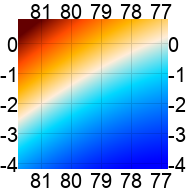

car:{cdelt:[0.03333,0.03333],crval:[0.01667,0],crpix:[-2304,126]}


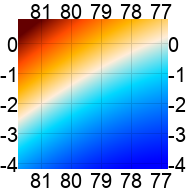

car:{cdelt:[0.03333,0.03333],crval:[0.01667,0],crpix:[-2304,126]}


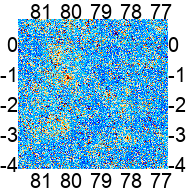

car:{cdelt:[0.03333,0.03333],crval:[0.01667,0],crpix:[-2304,126]}


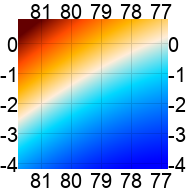

In [9]:
res_arcmin = 2.0
shape = (npix, npix)
stamp_dir = output_path("stamp_{}arcmin_{}x{}".format(res_arcmin, shape[0], shape[1]))

SS = maps.StampedSky(stamp_dir, res_arcmin, shape)

sim_idx = 1 

emap = SS.get_ksz(148, sim_idx)
print(emap.wcs)
enplot.pshow(emap, downgrade=1)

emap = SS.get_tsz(148, sim_idx)
print(emap.wcs)
enplot.pshow(emap, downgrade=1)

emap = SS.get_cib(148, sim_idx)
print(emap.wcs)
enplot.pshow(emap, downgrade=1)

emap = SS.get_radio(148, sim_idx)
print(emap.wcs)
enplot.pshow(emap, downgrade=1)
